In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('../SourceCode')
import bastien_utils
from AsymAE_infoGAN.nonNegSparseAsymAEinfoGAN import Sparse_NonNeg_AsymAEinfoGAN_KLsum_NonNegConstraint, Sparse_NonNeg_AsymAEinfoGAN_KLsum_NonNegConstraint_L1WeightsDecay
import datetime
import morphoMaths
import keras
import pandas as pd
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
#loading fashion_MNIST ()
FILE_PATH = "../"
x_train, y_train, x_test, y_test = bastien_utils.load_data_fashionMNIST(FILE_PATH, train=True, test=True, subsetTest=False)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [3]:
# the small subset of the test dataset used to show results 
idx_small = np.arange(10)
idx_small[2] = 31
idx_small[5] = 32
idx_small[7] = 35
x_small = x_test[idx_small]

In [4]:
#loading a trained AE
#the first argument is the model name
#the model has to be saved as a '.h5' file in the directory path_to_model_directory + 'Sparse_NonNeg/KLdivSum_NonNegConstraint/'
trainedAE = Sparse_NonNeg_AsymAEinfoGAN_KLsum_NonNegConstraint.load('18_09_05_dim100_KLdivSum_0.005_0.05_NonNegConstraint.h5', path_to_model_directory='../Results/MNIST_Fashion/AsymAE_infoGAN/')

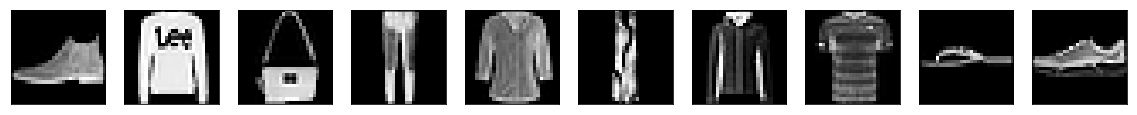

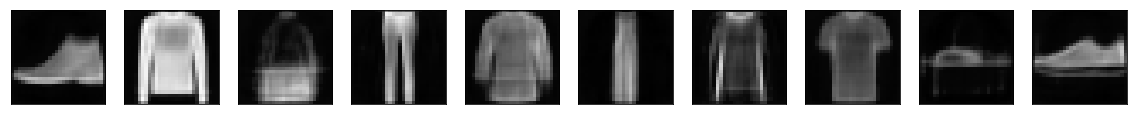

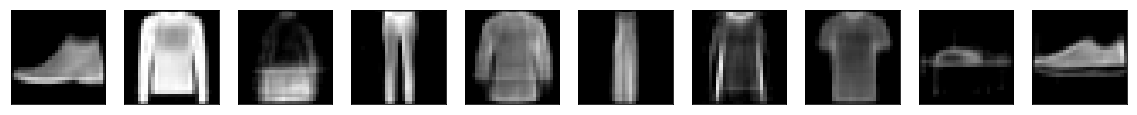

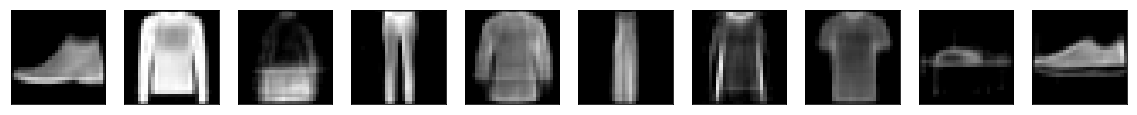

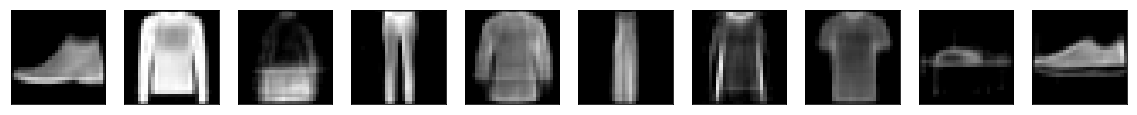

In [8]:
#computing the reconstructions of x_small by the trained AE
x_rec_small = trainedAE.reconstruction(x_small)
bastien_utils.plot_all_images(x_small)
bastien_utils.plot_all_images(x_rec_small)

#the following lines are equivalent (show the clipped version of the reconstructions)
bastien_utils.plot_all_images(x_rec_small, v_min=0, v_max=1)
bastien_utils.plot_all_images(np.clip(x_rec_small, 0, 1))
trainedAE.plot_reconstructions(x_small, same_scale_as_input=True, plot_input=False)

In [9]:
# creating a new AE, with sparsity regularizer of the encoding (KL), Non Neg Constraint of the atoms and enforcing sparsity of the atoms using L1 weight decay
AE_with_l1weightDecay = Sparse_NonNeg_AsymAEinfoGAN_KLsum_NonNegConstraint_L1WeightsDecay(sparsity_objective=0.05, sparsity_weight=0.005, l1_weight_decay=0.1)

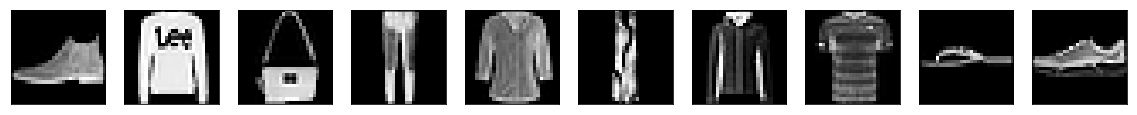

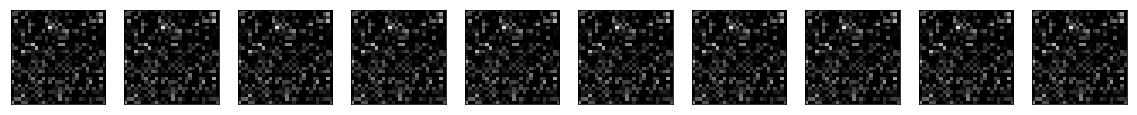

In [10]:
#obviously, it cannot reconstruct the images, since it has not been trained
AE_with_l1weightDecay.plot_reconstructions(x_small, same_scale_as_input=True)

In [11]:
#copying the weights from the trained AE
AE_with_l1weightDecay.copy_AE_weights(trainedAE)

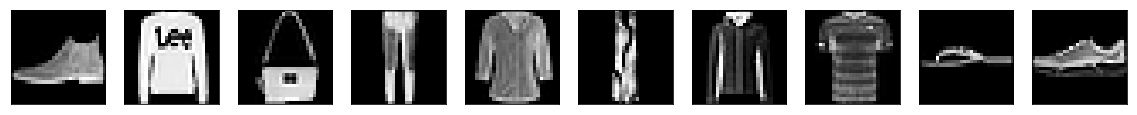

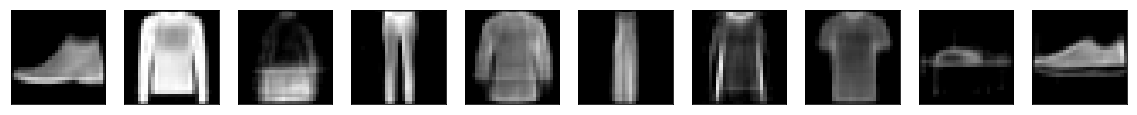

In [12]:
#now it can reconstrutc the images
AE_with_l1weightDecay.plot_reconstructions(x_small, same_scale_as_input=True)

In [15]:
# fine tuning the new AE with the additional L1 weight decay
AE_with_l1weightDecay.train(x_train, nb_epochs=1)

Epoch 1/1
60000/60000 [==============================] - 215s 4ms/step - loss: 3.5389 - mean_squared_error: 0.2051


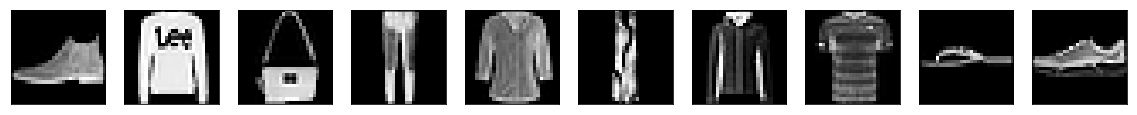

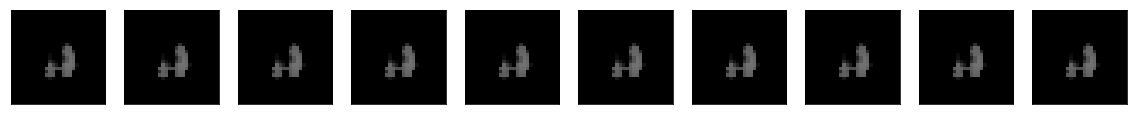

In [16]:
#let see how it modified the reconstruction
AE_with_l1weightDecay.plot_reconstructions(x_small, same_scale_as_input=True)

Of course, the weight of the l1 weight decay as to be tuned, probably along with the parameter of the KL regularizer (since the addition of the l1 weight decay modify the balance of the different terms in the total loss function). 

In [17]:
#computing the reconstruction error of the AE, without clipping the reconstruction
print(AE_with_l1weightDecay.reconstruction_error(x_test))
# with clipping
print(trainedAE.reconstruction_error(x_test, clipped_output=True))
# equivalent, vut we specify the values to which the reconstructions is clipped
print(trainedAE.reconstruction_error(x_test, clipped_output=True, v_min=0, v_max=1))

0.19711115951538086
0.011660315
0.011660315


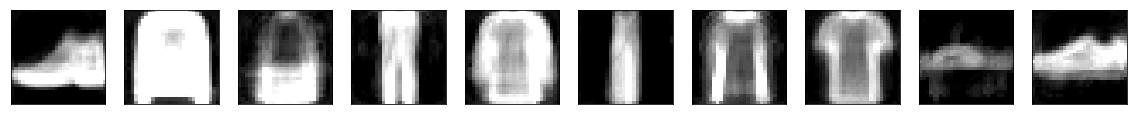

In [22]:
#computing the max_approximation
AE_dil = trainedAE.apply_operator_to_decoder_atoms(morphoMaths.dilatation, apply_to_bias=False, SE_scale=1)
max_approx_small = AE_dil.reconstruction(x_small)
bastien_utils.plot_all_images(max_approx_small, v_min=0, v_max=1)

In [23]:
#computing the max_approximation error, without clipping
trainedAE.max_approximation_error(x_test, morphoMaths.dilatation, clipped_max_approx=False, SE_scale=1)

(0.10324130321145057, 0.10684381484985352)

In [24]:
#computing the max_approximation error, with clipping to the min and max values of x_test
trainedAE.max_approximation_error(x_test, morphoMaths.dilatation, clipped_max_approx=True, SE_scale=1)

(0.0355854764040008, 0.037105544012703905)

In [26]:
#computing the max_approximation error, without clipping
trainedAE.max_approximation_error(x_test, morphoMaths.dilatation, clipped_max_approx=True, v_min=0, v_max=1, SE_scale=1)

(0.0355854764040008, 0.037105544012703905)

The first value is the mse between the  max-approximation and the dilation of the input images, the second is the mse between the max-approximation and the dilation of the reconstruction.

In [ ]:
#saving a model, it will be saved as a '.h5' file is the directory path_to_model_directory + 'Sparse_NonNeg/KLdivSum_NonNegConstraint_L1WeightDecay/'
#the model of the nale
AE_with_l1weightDecay.save(path_to_model_directory='../Results/Fashion_MNIST/AsymAE_infoGAN/')